In [1]:
!pip install pyAudioAnalysis

  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.4-py3-none-any.whl size=41160934 sha256=0c27607e215f20be7258a213663232bbef8e3972dce93e865a968902c56240af
  Stored in directory: c:\users\peter\appdata\local\pip\cache\wheels\f6\a9\31\905e34d3a445482bc61a947a155ee304850d5608bc80c73c5e
Successfully built pyAudioAnalysis


In [2]:
!pip install ffmpeg

  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6086 sha256=d7b676754c598f9181bc2e69e3a7766dc543cda26e79e6763b7968c9a5748c34
  Stored in directory: c:\users\peter\appdata\local\pip\cache\wheels\64\80\6e\caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Successfully built ffmpeg


In [4]:
!pip install python-magic

  Using cached python_magic-0.4.18-py2.py3-none-any.whl (8.6 kB)


In [ ]:
!pip install librosa

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy
from pyAudioAnalysis import audioBasicIO #don't really need pyaudioanalysis
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt
import librosa

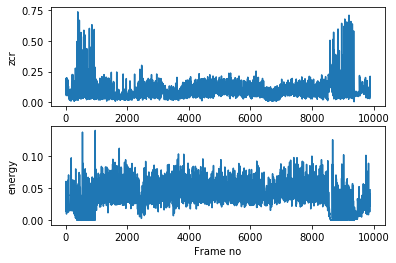

In [28]:
F, f_names = ShortTermFeatures.feature_extraction(x, Fs, 0.050*Fs, 0.025*Fs)
plt.subplot(2,1,1); plt.plot(F[0,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[0]) 
plt.subplot(2,1,2); plt.plot(F[1,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[1]); plt.show()

In [184]:
mfcc_y[1142]

array([1617.7356  ,    9.504004,    9.501856,    9.498279,    9.493274,
          9.486832,    9.478965,    9.469671,    9.458947,    9.446806,
          9.433239,    9.418251,    9.401849,    9.384023,    9.364787,
          9.344141,    9.3221  ,    9.298632,    9.273774,    9.24752 ],
      dtype=float32)

In [133]:
len(np.array(dummy['x']))

1177748

In [132]:
len(np.array(dummy['z']))

1177748

covariance:

6 combinations:
X X
X Y
X Z
Y Y
Z Z
Y Z

In [ ]:
#how merge_asof works: essentially a left join
right = pd.DataFrame({'a': [1, 5, 10], 'left_val': ['a', 'b', 'c']})
left = pd.DataFrame({'a': [1, 2, 3, 6, 7],
                      'right_val': [1, 2, 3, 6, 7]})
pd.merge_asof(left, right, on='a', direction = 'nearest')

In [337]:
mfcc_x.shape

(2301, 20)

In [338]:
#this doesn't really mean anything, just use the raw mfcc values
i = 1120
xx = numpy.cov(mfcc_x[i],mfcc_x[i])
xy = numpy.cov(mfcc_x[i],mfcc_y[i])
xz = numpy.cov(mfcc_x[i],mfcc_z[i])
yy = numpy.cov(mfcc_y[i],mfcc_y[i])
zz = numpy.cov(mfcc_z[i],mfcc_z[i])
yz = numpy.cov(mfcc_y[i],mfcc_z[i])

print(np.unique(np.array([xx,xy,xz,yy,zz,yz])))

print(mfcc_x[i])
print(mfcc_y[i])
print(mfcc_z[i])

[xx,xy,xz,yy,zz,yz]

[ 11824.1816815   38229.63696712 129335.25478723]
[ 4.8180322e+02  9.6060875e+01  2.2163577e+00 -3.4836602e+00
 -7.6950169e+00 -7.3327274e+00  5.9715122e-02 -4.0648327e+00
 -8.5183537e-01  2.8544383e+00 -2.9366438e+00  2.1930202e+01
  2.8203611e+01  1.6050758e+00  1.8779637e+00 -1.7232039e+00
  2.2548590e+00  2.4042110e+00 -2.6607952e+00 -6.9043326e+00]
[1617.7356      9.504004    9.501856    9.498279    9.493274    9.486832
    9.478965    9.469671    9.458947    9.446806    9.433239    9.418251
    9.401849    9.384023    9.364787    9.344141    9.3221      9.298632
    9.273774    9.24752 ]
[1617.7356      9.504004    9.501856    9.498279    9.493274    9.486832
    9.478965    9.469671    9.458947    9.446806    9.433239    9.418251
    9.401849    9.384023    9.364787    9.344141    9.3221      9.298632
    9.273774    9.24752 ]


[array([[11824.1816815, 11824.1816815],
        [11824.1816815, 11824.1816815]]),
 array([[ 11824.1816815 ,  38229.63696712],
        [ 38229.63696712, 129335.25478723]]),
 array([[ 11824.1816815 ,  38229.63696712],
        [ 38229.63696712, 129335.25478723]]),
 array([[129335.25478723, 129335.25478723],
        [129335.25478723, 129335.25478723]]),
 array([[129335.25478723, 129335.25478723],
        [129335.25478723, 129335.25478723]]),
 array([[129335.25478723, 129335.25478723],
        [129335.25478723, 129335.25478723]])]

In [99]:
np.unique(np.arraynumpy.cov(mfcc_x[0],mfcc_y[0]))

array([  1871.3346843 ,  13928.80987948, 129768.44920543])

In [82]:
len(mfcc[0])

20

In [58]:
#true sampling rate is 40hz, but pyaudioanalysis wont take anything less than 10000
Fsamp = 10000
ShortTermFeatures.feature_extraction(np.array(dummy['x']), Fsamp, 0.050*Fsamp, 0.025*Fsamp)

(array([[ 1.00200401e-02,  0.00000000e+00,  0.00000000e+00, ...,
          2.96593186e-01,  2.86573146e-01,  2.48496994e-01],
        [ 1.09568086e-04,  9.93730690e-06,  1.18593335e-05, ...,
          4.14436583e-05,  1.70556968e-04,  1.98719511e-04],
        [ 5.67684071e-01,  3.26405840e+00,  3.32087331e+00, ...,
          2.61296607e+00,  1.59050513e+00,  2.09756619e+00],
        ...,
        [ 0.00000000e+00, -4.44823262e-02, -5.68914087e-05, ...,
         -1.35077170e-02,  1.03252774e-02, -6.69548704e-03],
        [ 0.00000000e+00, -1.31814561e-03, -8.32165241e-06, ...,
          5.56672170e-03, -3.89243928e-03, -9.96017744e-04],
        [ 0.00000000e+00,  1.74909660e-02,  9.30680352e-04, ...,
         -1.92838833e-03, -5.92487500e-04, -1.29502064e-03]]),
 ['zcr',
  'energy',
  'energy_entropy',
  'spectral_centroid',
  'spectral_spread',
  'spectral_entropy',
  'spectral_flux',
  'spectral_rolloff',
  'mfcc_1',
  'mfcc_2',
  'mfcc_3',
  'mfcc_4',
  'mfcc_5',
  'mfcc_6',
  'mfcc_7

In [27]:
[Fs, x] = audioBasicIO.read_audio_file('scottish.wav')

In [51]:
Fs

16000

In [430]:
original = pd.read_pickle('joined.pkl')

In [431]:
ids = original.pid.unique()

dummy = original[original['pid'] == ids[0]]

df = original

In [220]:
#51 rows ~ 1 second, where time is in milliseconds

print(dummy['time'].iloc[0])
print(dummy['time'].iloc[50])

print(dummy['time'].iloc[51])
print(dummy['time'].iloc[101])

print(dummy['time'].iloc[102])
print(dummy['time'].iloc[152])

print(dummy['time'].iloc[153])
print(dummy['time'].iloc[203])

1493739732016
1493739733023
1493739733043
1493739734049
1493739734070
1493739735083
1493739735103
1493739736097


In [462]:
#calculate mfcc for each pid

start = datetime.now()

mfcc_df = pd.DataFrame(columns = (mfcc(df, ids[0])).columns)

for i in range(len(ids)):
    mfcc_df = mfcc_df.append(mfcc(df,ids[i]))
    
df = mfcc_df
    
end = datetime.now()

end - start

In [465]:
#calculate rms for x, y, and z for each pid

start = datetime.now()

rms_df = pd.DataFrame(columns = (rms(df, ids[0])).columns)

for i in range(len(ids)):
    rms_df = rms_df.append(rms(df,ids[i]))
    
df = rms_df
    
end = datetime.now()

end - start

In [467]:
#this may give you a memory error.  it's really big.

#perform 2 tier rolling window analysis on 
#mean, median, and std of x, y, and z for each pid

start = datetime.now()

for ii in ['x','y','z']:

    extract_df = pd.DataFrame(columns = (extract(df, ids[0], ii)).columns)

    for i in range(len(ids)):
        extract_df = extract_df.append(extract(df,ids[i], ii))

    df = extract_df
    
end = datetime.now()

MemoryError: Unable to allocate 5.69 GiB for an array with shape (81, 9424032) and data type float64

In [470]:
df

,index,time,pid,x,y,z,TAC_Reading,0_x,1_x,2_x,...,x_std_mean,x_std_var,x_std_max,x_std_min,x_std_first_diff,x_std_fifth_diff,x_std_mean_diff,x_std_var_diff,x_std_max_diff,x_std_min_diff
0,0,1493739732016,JB3156,-2.556815,8.312009,14.090558,0.035549,189.120316,53.257515,53.779331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1493739732035,JB3156,-2.499538,8.636412,13.906186,0.035549,189.120316,53.257515,53.779331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1493739732055,JB3156,-2.471458,8.687223,13.677473,0.035549,189.120316,53.257515,53.779331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1493739732075,JB3156,-2.244561,8.832140,13.288850,0.035549,189.120316,53.257515,53.779331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1493739732095,JB3156,-2.453742,9.053032,12.610379,0.035549,189.120316,53.257515,53.779331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339617,14057560,1493809885629,DK3500,-0.000800,0.000500,0.006300,0.011943,-216.527130,-8.199280,-10.006081,...,0.000600,1.667797e-10,0.000620,0.000587,0.000085,0.000035,0.000066,-4.237393e-10,0.000050,0.000050
1339618,14057561,1493809885654,DK3500,0.001000,-0.000300,0.006100,0.011943,-216.527130,-8.199280,-10.006081,...,0.000600,1.637669e-10,0.000620,0.000586,0.000085,0.000035,0.000066,-4.289522e-10,0.000050,0.000050
1339619,14057562,1493809885679,DK3500,-0.000200,-0.000100,0.006300,0.011943,-216.527130,-8.199280,-10.006081,...,0.000600,1.608379e-10,0.000620,0.000586,0.000085,0.000035,0.000066,-4.341753e-10,0.000049,0.000049
1339620,14057563,1493809885705,DK3500,-0.001100,0.000100,0.006700,0.011943,-216.527130,-8.199280,-10.006081,...,0.000600,1.580380e-10,0.000620,0.000586,0.000085,0.000034,0.000066,-4.393217e-10,0.000049,0.000049


In [454]:
second = df[df['pid'] == ids[1]].copy().reset_index()

In [458]:
pd.DataFrame(mfcc_z).index * expansion_z

RangeIndex(start=0, stop=1178112, step=512)

In [460]:
def mfcc(df, pid):
    
    #give whole df, one pid at a time
    
    df = df[df['pid'] == pid].copy().reset_index()
    
    Fs = 40
    mfcc_x_array = librosa.feature.mfcc(np.array(df['x']), sr=Fs).T
    mfcc_y_array = librosa.feature.mfcc(np.array(df['y']), sr=Fs).T
    mfcc_z_array = librosa.feature.mfcc(np.array(df['z']), sr=Fs).T

    x_mfcc = pd.DataFrame(mfcc_x_array)
    y_mfcc = pd.DataFrame(mfcc_y_array)
    z_mfcc = pd.DataFrame(mfcc_z_array)

    expansion_x = round(len(df)/len(x_mfcc))
    new_index_x = (pd.DataFrame(x_mfcc).index * expansion_x)
    x_mfcc.index = new_index_x

    expansion_y = round(len(df)/len(y_mfcc))
    new_index_y = (pd.DataFrame(y_mfcc).index * expansion_y)
    y_mfcc.index = new_index_x

    expansion_z = round(len(df)/len(z_mfcc))
    new_index_z = (pd.DataFrame(z_mfcc).index * expansion_z)
    z_mfcc.index = new_index_z

    df = pd.merge_asof(df,x_mfcc, left_index = True, right_index = True)
    df = pd.merge_asof(df,y_mfcc, left_index = True, right_index = True)
    df = pd.merge_asof(df,z_mfcc, left_index = True, right_index = True)
 
    #new_names = [(i,i+'_z') for i in df.iloc[:, 6:].columns.values]
    #df.rename(columns = dict(new_names), inplace=True)

    return df

In [374]:
def rms(df,pid):
    
    #give whole df, one pid at a time
    
    df = df[df['pid'] == pid].copy()
    
    sec = 51
    short = sec*2
    full = sec*10
    
    df['x_rms'] = ((df['x']**2)**.5).rolling(window=short).mean()
    df['y_rms'] = ((df['y']**2)**.5).rolling(window=short).mean()
    df['z_rms'] = ((df['z']**2)**.5).rolling(window=short).mean()
    
    return df

In [375]:
def extract(df,pid,feature):
    
    #give this x, y, z, for each pid
    
    df = df[df['pid'] == pid].copy()
    
    df[feature + '_mean'] = df[feature].rolling(window=full).mean()
    df[feature + '_median'] = df[feature].rolling(window=full).median()
    df[feature + '_std'] = df[feature].rolling(window=full).std()
    
    df = summarize(df,pid,feature + '_mean')
    df = summarize(df,pid,feature + '_median')
    df = summarize(df,pid,feature + '_std')
    
    return df

In [376]:
def summarize(df,pid,feature):
    
    #called by extract, don't call separately
    
    #feature: mean over rolling window of 10 seconds
    #break into windows of 2 seconds
    #take mean, variance, max, min of those 5 windows as new features
    #take mean of bottom 2 seconds and mean of top 2 seconds as new features
    
    df = df[df['pid'] == pid].copy()
    
    sec = 51
    short = sec*2
    full = sec*10
    
    df[feature + '_first'] = df[feature].shift(short*4).rolling(window=short).mean()
    df['second'] = df[feature].shift(short*3).rolling(window=short).mean()
    df['third'] = df[feature].shift(short*2).rolling(window=short).mean()
    df['fourth'] = df[feature].shift(short*1).rolling(window=short).mean()
    df[feature + '_fifth'] = df[feature].rolling(window=short).mean()
    
    df[feature + '_mean'] = df[[feature + '_first', 'second', 
                                'third', 'fourth', feature + '_fifth']].mean(axis=1)
    
    df[feature + '_var'] = df[[feature + '_first', 'second', 
                                'third', 'fourth', feature + '_fifth']].var(axis=1)
    
    df[feature + '_max'] = df[[feature + '_first', 'second', 
                                'third', 'fourth', feature + '_fifth']].max(axis=1)
    
    df[feature + '_min'] = df[[feature + '_first', 'second', 
                                'third', 'fourth', feature + '_fifth']].min(axis=1)
    
    df.drop(['second','third','fourth'],axis = 1, inplace = True)
    
    df[feature + '_first' + '_diff'] = df[feature + '_first'].diff(periods = full)
    df[feature + '_fifth' + '_diff'] = df[feature + '_fifth'].diff(periods = full)
    df[feature + '_mean' + '_diff'] = df[feature + '_mean'].diff(periods = full)
    df[feature + '_var' + '_diff'] = df[feature + '_var'].diff(periods = full)
    df[feature + '_max' + '_diff'] = df[feature + '_max'].diff(periods = full)
    df[feature + '_min' + '_diff'] = df[feature + '_max'].diff(periods = full)

    return df
    

In [471]:
 def getZeroCrossingRate(arr):
        my_array = np.array(arr)
        return float("{0:.2f}".format((((my_array[:-1] * my_array[1:]) < 0).sum())/len(arr)))

In [ ]:
def zerocross(df,pid):
    
    #takes full df and specific pid to work on
    #apply to windows (rolling.apply didn't seem to work)
    
    df = df[df['pid'] == pid].copy()
    
    sec = 51
    short = sec*2
    full = sec*10
    
    #df['x_cross'] =

In [474]:
getZeroCrossingRate(np.array(dummy['x']))

0.13

In [480]:
df.to_pickle('./semi_processed.pkl')

MemoryError: 